<img src = "Applied_Data_Science_Capstone.png" alt="IBM Course Logo" width = 100 align=right>

<h1 align=left><font size = 5>Identifying New Dealer Locations for an OEM</font></h1>
  
<i align=left><font size = 3>IBM Applied Data Science Capstone Project | Amol Sangeet</font></i>

## Introduction

In this document, I create and present my Capstone project for IBM's Data Science Professional Certification on Coursera. The project objective is to help an auto OEM scout for and identify potential dealership locations by following competitors, as well as, using other proxy information like availability of banking facilities, hotels and other places indicative of commercial activity and financial well-being.


<a id='home'></a>

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol type='1'>
        <li><a href="#itemA">The Business Problem & Data Requirement</a></li>
        <li><a href="#itemB">Methodology</a></li>
        <ol type="A">
            <li><a href="#item1">Load and map the Honda Cars India Dealers Network</a></li>
            <li><a href="#item2">Load the Maharashtra Districts data</a></li>
            <li><a href="#item3">Fetching and Using Foursquare Data</a></li>
            <li><a href="#item4">Cluster Neighbourhoods</a></li>
        </ol>
        <li><a href="#itemC">Results & Discussion</a></li>
        <li><a href="#itemD">Conclusion</a></li>
    </ol>
</div>

<a id='itemA'></a>

## 1. The Business Problem & Data Requirement

<div style="text-align: right"><a href="#home"><i><font size = 3 align=right>Home</font ></i></a></div>

Companies that need to enter new geographies or increase penetration in existing geographies have to routinely address the problem of identifying locations for new dealerships or sales outlets. While geographic gaps can easliy be identified on the map, the target locations should also have business potential for the company as represented by current market size, competitor sales, overall economic environment etc.

This project tries to address this problem for an auto OEM by identifying locations for setting up new dealerships in the 
state of Maharashtra, India, where it is seeking to increase its market penetration.

The approach adopted for this is to collect data on the presence of competitors and shortlist locations where the competitors are present but the OEM is not. The OEM that is used for the project is Honda Cars India. While Honda already has a presence in Maharashtra, it needs to expand its dealership network within the state. For this, let's assume that it has decided to track the presence of other OEMs indicating where the market potential is. 

However, every location where competitors have a dealer may not result in business for Honda. It would also need more data on other factors like, say, availability of banking facilities around the target location, income levels of the local population, wealth generation potential etc. For the purpose of this project the data sources are limited to the Foursquare API, OEM websites, and Wikipedia. However, it is understood that in practice, the OEM may have and use data on rival dealer sales, demographic information etc. which is not available on Foursquare API or on the OEM websites.

Hence, the data that we will sift through is other auto dealer locations, bank branches, hotels, restaurants, and perhaps other retail outlets, if any, and using the k-means clustering algorithm  shortlist locations which have a rival dealers but no Honda dealer, and venues from categories like banks, hotels etc. within a 3 km radius.


Before we get the data and start exploring it, let's download all the libraries that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't installed Geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#from shapely.geometry import Point, Polygon

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't installed Folium
import folium # map rendering library
from folium import plugins

print('Libraries imported.')

Libraries imported.


<a id='itemB'></a>

## 2. Methodology
<div style="text-align: right"><a href="#home"><i><font size = 3 align=right>Home</font ></i></a></div>

<div>
    <ol type="i">
        <p><li>We will first load the Honda dealer network data obtained from the company's India website.</li></p>
        <p><li>Next, we will load data for each district of Maharashtra which will be filtered to shortlist districts with significant market potential.</li></p>
        <p><li>Next we will fetch dealer data for other OEMs from Foursquare API for each of the shortlisted districts.</li></p>
        <p><li>For the Honda, as well as, other dealers we need to get standardized addresses which will facilitate geographical comparison. This will be done using reverse geocoding with the **geolocator.reverse()** funtion in **GeoPy**.</li></p>
        <p><li>For each of the standardized addresses for other OEM dealers, we will use the **search** function in the **Foursquare API** to explore the neighbourhood for other venue categories that would represent, and be a proxy for, economic activity, lifestyle, and availability of finance. For economic activity, we shall explore Office venues and Hotels; for lifestyle data, we shall use restaurants and nightlife category venues; and, for access to finance we shall look for presence of leading private sector banks. This entire activity would indicate the market potential in the neighbourhood.</li></p>
        <p><li>Combining all this data, we shall prepare it for clustering by first grouping the data based on addresses and use **one-hot encoding** to get the totals of venues per address. Then, we shall perform ***k*-means clustering** to identify geographical clusters which the company should target for new dealers. While we need 2-3 broad categories, we can use the Elbow Method to confirm whether this would be an appropriate number.</li></p>
        <p><li>We will end with understanding how this project, if required, can be applied in a live situation and what additional data could be useful.</li></p>
    </ol>
</div>

<a id='item1'></a>

### A. Honda Cars India Ltd. data
<div style="text-align: right"><a href="#home"><i><font size = 3 align=right>Home</font ></i></a></div>

#### Load the Honda Cars India dealer network dataset

This has been scraped from the Honda website and downloaded into a CSV file which will be used as the source.

In [3]:
df_honda = pd.read_csv('Honda-Dealers.csv')
df_honda.head()

,Dealer Code,Dealer Name,Dealer Type,Lat,Long,Distance,Company,Address,City,Email,Phone,Fax,SMS
0,DD313,Ring Road Honda,Showroom & Workshop,28.68060,77.08994,NaN,Sugoi Motors pvt ltd,"A-2 Udyog Nagar Indl. Area, Rohtak Road",DELHI,telemktg@rrhonda.com,"01145520000, 01145540000",011- 45540050,SMS Address
1,DD020,Prime Honda,Showroom & Workshop,28.64599,77.33332,NaN,Capital Cars Pvt. Ltd.,"Ansal Plaza, Main Link Road (Opp. Dabur Facto...",GHAZIABAD,crmsalesvaishali@primehonda.comcustomercare@pr...,"7290055379, 7375004989, 01204184200",NaN,SMS Address
2,DD109,Courtesy Honda,Showroom & Workshop,30.71387,76.80975,NaN,Lally Automobiles Pvt. Ltd.,"Plot No. 6., Indl. Area Phase - I",CHANDIGARH,saleschd@lallyautomobiles.netsalesheadchd@lall...,1723067777,0172-3067700,SMS Address
3,DD004,Prestige Honda,Showroom & Workshop,31.29380,75.65388,NaN,Lally Motors Ltd.,"Pragpur,G.T.Road",JALANDHAR,salesjal@lallymotors.netripu@lallymotors.net,1813067777,0181-3067700,SMS Address
4,DD024,Prestige Honda,Showroom & Workshop,31.60418,74.93701,NaN,Lally Motors Ltd.,"G.T ROAD, SULTANWIND",AMRITSAR,salesamr@lallymotors.netripu@lallymotors.net,1833067777,0183-3067770,SMS Address


We need a standardized dealer address which will be comparable with other addresses generated during this process.

In [5]:
geolocator = Nominatim(user_agent="mh_explorer")

dlr_addresses = list()
for lat, lng in zip(df_honda['Lat'], df_honda['Long']):
    area = geolocator.reverse([lat,lng])
    dlr_address = area.raw.get('address').get('suburb', area.raw.get('address').get('road')), area.raw.get('address').get('county'), area.raw.get('address').get('state_district')
    dlr_address = ', '.join(str(i) or '' for i in dlr_address)
    dlr_addresses.append(dlr_address)

df_honda['dlr_address'] = dlr_addresses
df_honda.head()

,Dealer Code,Dealer Name,Dealer Type,Lat,Long,Distance,Company,Address,City,Email,Phone,Fax,SMS,dlr_address
0,DD313,Ring Road Honda,Showroom & Workshop,28.68060,77.08994,NaN,Sugoi Motors pvt ltd,"A-2 Udyog Nagar Indl. Area, Rohtak Road",DELHI,telemktg@rrhonda.com,"01145520000, 01145540000",011- 45540050,SMS Address,"Udyog Vihar, Punjabi Bagh Tehsil, West Delhi"
1,DD020,Prime Honda,Showroom & Workshop,28.64599,77.33332,NaN,Capital Cars Pvt. Ltd.,"Ansal Plaza, Main Link Road (Opp. Dabur Facto...",GHAZIABAD,crmsalesvaishali@primehonda.comcustomercare@pr...,"7290055379, 7375004989, 01204184200",NaN,SMS Address,"Kaushambi, Ghaziabad, None"
2,DD109,Courtesy Honda,Showroom & Workshop,30.71387,76.80975,NaN,Lally Automobiles Pvt. Ltd.,"Plot No. 6., Indl. Area Phase - I",CHANDIGARH,saleschd@lallyautomobiles.netsalesheadchd@lall...,1723067777,0172-3067700,SMS Address,"None, None, Chandigarh"
3,DD004,Prestige Honda,Showroom & Workshop,31.29380,75.65388,NaN,Lally Motors Ltd.,"Pragpur,G.T.Road",JALANDHAR,salesjal@lallymotors.netripu@lallymotors.net,1813067777,0181-3067700,SMS Address,"None, Jalandhar I Tahsil, Jalandhar"
4,DD024,Prestige Honda,Showroom & Workshop,31.60418,74.93701,NaN,Lally Motors Ltd.,"G.T ROAD, SULTANWIND",AMRITSAR,salesamr@lallymotors.netripu@lallymotors.net,1833067777,0183-3067770,SMS Address,"GT Road; Sher Shah Suri Marg, Amritsar II Tahs..."


In [6]:
df_honda.dtypes

Dealer Code     object
Dealer Name     object
Dealer Type     object
Lat            float64
Long           float64
Distance       float64
Company         object
Address         object
City            object
Email           object
Phone           object
Fax             object
SMS             object
dlr_address     object
dtype: object

In [7]:
df_honda.shape
print('There are', df_honda.shape[0], 'dealers in the dataset.')

There are 383 dealers in the dataset.


#### Plotting all the Honda dealers on the India map

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>mh_explorer</em>, as shown below.

In [8]:
address = 'Maharashtra, India'
location = geolocator.geocode(address)
MH_latitude = location.latitude
MH_longitude = location.longitude
print('The geograpical coordinate of Maharashtra, India are {}, {}.'.format(MH_latitude, MH_longitude))

The geograpical coordinate of Maharashtra, India are 19.531932, 76.0554568.


In [9]:
honda_map = folium.Map(location=[MH_latitude+1, MH_longitude+5], zoom_start=4)

# instantiate a mark cluster object for the incidents in the dataframe
# dmarkers = plugins.MarkerCluster().add_to(honda_map)


# add the catogories as blue circle markers
for lat, lng, label, name, addr in zip(
    df_honda.Lat, 
    df_honda.Long, 
    df_honda['Dealer Type'], 
    df_honda['Dealer Name'], 
    df_honda['City']):
    
    if label == "Workshop":
        clr = 'green'
    elif label == 'Showroom & Workshop':
        clr = 'red'
    else: clr = 'yellow'
    
    tag = str(name).strip() + ', ' + str(addr).title()
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color=clr,
        popup=folium.Popup(tag),
        fill = True,
        fill_color=clr,
        fill_opacity=0.6
#     ).add_to(dmarkers) #if using a MarkerCluster
    ).add_to(honda_map)

# display map
honda_map

Now that we know where Honda has its dealers, let's being to identify where it needs to have new ones.

  <a id='item2'></a>

### B. Load Data on Maharashtra Districts
<div style="text-align: right"><a href="#home"><i><font size = 3 align=right>Home</font ></i></a></div>

#### Get the list of districts and related details from Wikipedia

In [10]:
urlMH = 'https://en.wikipedia.org/wiki/List_of_districts_of_Maharashtra'
dfs = pd.read_html(urlMH)
df_raw = dfs[1]
df_raw.head()

,No,Name,Code,Formed,Headquarters,AdministrativeDivision,Area (km2),Population (2011 Census),Population(2001 census),% of StatePopulation,Density(per km2),Urban (%),Literacy (%),Sex ratio,Tehsils,Source
0,1,Ahmednagar,AH,1 May 1960,Ahmednagar,Nashik,17413.0,4543159.0,4088077,NaN,234.77,19.67,80.22,941.0,14,District website
1,2,Akola,AK,1 May 1960,Akola,Amravati,5417.0,1813906.0,1818617,NaN,300.78,44.04,88.05,938.0,7,District website
2,3,Amravati,AM,1 May 1960,Amravati,Amravati,12626.0,2888445.0,2606063,NaN,206.40,34.50,82.50,838.0,14,District website
3,4,Aurangabad,AU,1 May 1960,Aurangabad,Aurangabad,10100.0,3701282.0,2897013,NaN,286.83,37.53,61.15,924.0,9,District website
4,5,Beed,BI,1 May 1960,Beed,Aurangabad,10439.0,2585049.0,2161250,NaN,207.04,17.91,68.00,936.0,11,District website


#### Clean and retain only the relevant data

In [11]:
df_MH = df_raw[['Name', 'Headquarters', 'Population(2001 census)', 'Urban (%)']]
df_MH.columns = ['Name', 'HQ', 'Population', 'Urban%']
df_MH = df_MH[df_MH['Name'] != "-"]
df_MH['Population'] = df_MH['Population'].str.replace(r'\(2011\)', '')
df_MH['Population'] = df_MH['Population'].str.replace(r',', '')
df_MH

,Name,HQ,Population,Urban%
0,Ahmednagar,Ahmednagar,4088077,19.67
1,Akola,Akola,1818617,44.04
2,Amravati,Amravati,2606063,34.50
3,Aurangabad,Aurangabad,2897013,37.53
4,Beed,Beed,2161250,17.91
5,Bhandara,Bhandara,1135835,15.44
6,NaN,NaN,NaN,NaN
7,Buldhana,Buldhana,2232480,21.20
8,Chandrapur,Chandrapur,2071101,32.11
9,Dhule,Dhule,1707947,26.11


Check dataframe size and column datatypes:

In [12]:
df_MH.dropna(axis=0, inplace=True)
df_MH.reset_index(drop=True)

,Name,HQ,Population,Urban%
0,Ahmednagar,Ahmednagar,4088077,19.67
1,Akola,Akola,1818617,44.04
2,Amravati,Amravati,2606063,34.50
3,Aurangabad,Aurangabad,2897013,37.53
4,Beed,Beed,2161250,17.91
5,Bhandara,Bhandara,1135835,15.44
6,Buldhana,Buldhana,2232480,21.20
7,Chandrapur,Chandrapur,2071101,32.11
8,Dhule,Dhule,1707947,26.11
9,Gadchiroli,Gadchiroli,970294,6.93


In [13]:
print(df_MH.dtypes)
print(df_MH.shape)

Name           object
HQ             object
Population     object
Urban%        float64
dtype: object
(36, 4)


Change the datatype of Population column to numeric to facilitate logical comparison: 

In [14]:
df_MH = df_MH.apply(pd.to_numeric, errors='ignore')
df_MH.dtypes

Name           object
HQ             object
Population      int64
Urban%        float64
dtype: object

#### Create and apply threshold population critea to retain districts presenting a sizeable market

In [15]:
p_criteria = 3000000 # Population of 3 mn used as a threshold criteria
df_MH = df_MH[df_MH['Population'] > p_criteria]
# df_MH = df_MH.drop(df_MH[['Retain']], axis=1)
df_MH.reset_index(inplace=True, drop=True)
df_MH

,Name,HQ,Population,Urban%
0,Ahmednagar,Ahmednagar,4088077,19.67
1,Jalgaon,Jalgaon,3679936,71.40
2,Kolhapur,Kolhapur,3515413,29.65
3,Mumbai City,Mumbai,3326837,100.00
4,Mumbai Suburban,Bandra,8587000,100.00
5,Nagpur,Nagpur,4051444,64.33
6,Nashik,Nashik,4993796,38.80
7,Pune,Pune,7224224,58.10
8,Solapur,Solapur,3849543,31.80
9,Thane,Thane,8131849,72.58


In [16]:
print('There are', df_MH.shape[0], 'districts with population greater than', p_criteria, 'and which need to be explored.')

There are 10 districts with population greater than 3000000 and which need to be explored.


#### Get the coordinates for each of the districts

In [17]:
geolocator = Nominatim(user_agent="mh_explorer")
dist = df_MH['HQ']
i = 0
for d in dist:
    address = d + ' Railway Station, Maharashtra' # adding 'Railway Station' to avoid getting the geo centre of the dist.
    location = geolocator.geocode(address)
    df_MH.loc[i, 'Latitude'] = location.latitude
    df_MH.loc[i, 'Longitude'] = location.longitude
    i=i+1
df_MH.head(20)

,Name,HQ,Population,Urban%,Latitude,Longitude
0,Ahmednagar,Ahmednagar,4088077,19.67,19.479727,73.926871
1,Jalgaon,Jalgaon,3679936,71.40,20.961377,75.626324
2,Kolhapur,Kolhapur,3515413,29.65,16.702325,74.238298
3,Mumbai City,Mumbai,3326837,100.00,18.938771,72.835335
4,Mumbai Suburban,Bandra,8587000,100.00,19.055069,72.840144
5,Nagpur,Nagpur,4051444,64.33,21.152709,79.088107
6,Nashik,Nashik,4993796,38.80,20.011247,73.790236
7,Pune,Pune,7224224,58.10,18.528877,73.874415
8,Solapur,Solapur,3849543,31.80,17.671527,75.897550
9,Thane,Thane,8131849,72.58,19.184463,72.970678


With the geo coordinates for each district identified, we can now explore each of these districts.

<a id='item3'></a>

### C. Fetching and Using Foursquare Data for Various Venue Categories
<div style="text-align: right"><a href="#home"><i><font size = 3 align=right>Home</font ></i></a></div>

#### Define Foursquare Credentials and Version

In [18]:
CLIENT_ID = 'XEVMQDOYHYB1EGSN1FBA32MDQLFS40YAKM2BLGXKS1HDUA30' # your Foursquare ID
CLIENT_SECRET = 'RX0EMD3JW23HTEM0MFPP5VIGYTYYSI5VKYFDRATD2KSV4NI2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XEVMQDOYHYB1EGSN1FBA32MDQLFS40YAKM2BLGXKS1HDUA30
CLIENT_SECRET:RX0EMD3JW23HTEM0MFPP5VIGYTYYSI5VKYFDRATD2KSV4NI2


#### Get the list of auto dealers that are in each of the districts

In [19]:
# type your answer here
search_query = 'maruti'
category_id = '4eb1c1623b7b52c0e1adc2ec' # Auto Dealerships
# category_id = '4bf58dd8d48988d10a951735' # Banks
# category_id = '4bf58dd8d48988d1fa931735' # Hotels
radius = 30000
LIMIT = 100

In [20]:
venues = []
for district_latitude, district_longitude in zip(df_MH['Latitude'], df_MH['Longitude']):
    url_auto = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&ll={},{}&search_query={}&v={}&radius={}&limit={}'.format(category_id, CLIENT_ID, CLIENT_SECRET, district_latitude, district_longitude, search_query, VERSION, radius, LIMIT)
    
    # Send the GET request and examine the results
    for v in requests.get(url_auto).json()['response']['venues']:
        venues.append([v['name'], v['categories'][0]['name'], v['location']['lat'], v['location']['lng'], v['id'], ''])

df = pd.DataFrame(venues)
df.head()

,0,1,2,3,4,5
0,Suzuki,Auto Dealership,21.002715,75.585215,4f1ff378e4b037d57e5dd219,
1,Sai Service,Auto Dealership,16.696950,74.235068,521f2c5911d2dc27a4898b46,
2,Suzuki,Auto Dealership,16.703188,74.244753,4f5b677ee4b01219ab144978,
3,Millennium Honda Warehouse,Automotive Shop,16.867617,74.578270,50af5497e4b034c5d7526307,
4,Hyundai,Auto Dealership,16.711826,74.265060,4f5a2aa7e4b00984bdef87b3,


venues = requests.get(url).json()['response'] ['venues']
venues
print(len(venues))

In [21]:
headers = ['name', 'category', 'lat', 'lng', 'id', 'address']
df.columns = headers

In [22]:
addresses = list()
for lat, lng in zip(df['lat'], df['lng']):
    area = geolocator.reverse([lat,lng])
    daddress = area.raw.get('address').get('suburb', area.raw.get('address').get('road')), area.raw.get('address').get('county'), area.raw.get('address').get('state_district')
    daddress = ', '.join(str(i) or '' for i in daddress)
    addresses.append(daddress)

df['address'] = addresses
df['group'] = 'Auto'
df.head()

,name,category,lat,lng,id,address,group
0,Suzuki,Auto Dealership,21.002715,75.585215,4f1ff378e4b037d57e5dd219,"Asoda, Jalgaon, Jalgaon",Auto
1,Sai Service,Auto Dealership,16.696950,74.235068,521f2c5911d2dc27a4898b46,"Rajarampuri, Kolhapur, Kolhapur district",Auto
2,Suzuki,Auto Dealership,16.703188,74.244753,4f5b677ee4b01219ab144978,"None, Kolhapur, Kolhapur district",Auto
3,Millennium Honda Warehouse,Automotive Shop,16.867617,74.578270,50af5497e4b034c5d7526307,"None, Miraj, Sangli district",Auto
4,Hyundai,Auto Dealership,16.711826,74.265060,4f5a2aa7e4b00984bdef87b3,"None, Kolhapur, Kolhapur district",Auto


#### Generate the list of all addresses / areas where auto dealers are found in the selected districts

Extract the **address** column from **df**

In [23]:
df_addresses = df[['address']]
df_addresses.shape

(161, 1)

Remove duplicates

In [24]:
df_addresses = df[['address']].drop_duplicates()
df_addresses.shape

(56, 1)

In [25]:
df_addresses['address']=df_addresses['address'].str.replace('None, ', '')
df_addresses = df_addresses.reset_index(drop=True)

In [26]:
df_addresses

,address
0,"Asoda, Jalgaon, Jalgaon"
1,"Rajarampuri, Kolhapur, Kolhapur district"
2,"Kolhapur, Kolhapur district"
3,"Miraj, Sangli district"
4,"NH166, Kolhapur, Kolhapur district"
5,"Shree Nagar, Thane, Thane"
6,"New Panvel, Panvel, Raigad"
7,"P/S Ward, Mumbai Suburban"
8,"K/W Ward, Kulāba, Mumbai Suburban"
9,"Kharghar, Panvel, Raigad"


#### Get the geo-coordinates for each of the addresses

In [27]:
i = 0
for addr in df_addresses['address']:
    location = geolocator.geocode(addr)
    df_addresses.loc[i, 'addr_lat'] = location.latitude
    df_addresses.loc[i, 'addr_lng'] = location.longitude
#     print(addr, '\n', type(addr), '\n', location, '\n')
    i=i+1
df_addresses.head()

,address,addr_lat,addr_lng
0,"Asoda, Jalgaon, Jalgaon",21.041181,75.606734
1,"Rajarampuri, Kolhapur, Kolhapur district",16.694377,74.245285
2,"Kolhapur, Kolhapur district",16.702841,74.240533
3,"Miraj, Sangli district",16.858516,74.710895
4,"NH166, Kolhapur, Kolhapur district",16.706823,74.218190


#### Explore and compile data on different venue categories at each of the above addresses

In [28]:
radius = 3000 # 3 kms for each address
LIMIT = 30 # 30 venues

#### Explore all addresses for hotels in the vicinity

In [29]:
venues_hotels = []
category_id = '4bf58dd8d48988d1fa931735' # Hotels
for lat, lng, address in zip(df_addresses['addr_lat'], df_addresses['addr_lng'], df_addresses['address']):
    url = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&ll={},{}&search_query={}&v={}&radius={}&limit={}'.format(category_id, CLIENT_ID, CLIENT_SECRET, lat, lng, search_query, VERSION, radius, LIMIT)
    
    # Send the GET request and examine the results
    for v in requests.get(url).json()['response']['venues']:
        venues_hotels.append([v['name'], v['categories'][0]['name'], v['location']['lat'], v['location']['lng'], v['id'], address])

df_hotels = pd.DataFrame(venues_hotels)
df_hotels.columns = headers

df_hotels['group'] = 'Hotel'
df_hotels.head()

,name,category,lat,lng,id,address,group
0,Hotel woodland,Hotel,16.709844,74.240541,4f50b918e4b0b71c793fc246,"Rajarampuri, Kolhapur, Kolhapur district",Hotel
1,Hotel Atria,Hotel,16.705495,74.245206,4ec217164690d2338a5fbf26,"Rajarampuri, Kolhapur, Kolhapur district",Hotel
2,Hotel Raysons Regency,Hotel,16.704170,74.239640,4bce162ccc8cd13adcb7c3cf,"Rajarampuri, Kolhapur, Kolhapur district",Hotel
3,Hotel Shalini Palace,Resort,16.695491,74.217672,4f5863a9e4b0b14569dc13c7,"Rajarampuri, Kolhapur, Kolhapur district",Hotel
4,"Hotel Maratha Regency, Kolhapur",Bed & Breakfast,16.694874,74.223404,4eecc0e18231688f1d85e3f9,"Rajarampuri, Kolhapur, Kolhapur district",Hotel


#### Explore all addresses for restaurants in the vicinity

In [30]:
venues_restaurants = []
# category_id = '4d4b7105d754a06374d81259' # Food
# category_id = '4bf58dd8d48988d16d941735' # Cafe
# category_id = '4bf58dd8d48988d1e0931735' # Coffee Shop
category_id = '4bf58dd8d48988d110941735' # Italian Restaurant

for lat, lng, address in zip(df_addresses['addr_lat'], df_addresses['addr_lng'], df_addresses['address']):
    url = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&ll={},{}&search_query={}&v={}&radius={}&limit={}'.format(category_id, CLIENT_ID, CLIENT_SECRET, lat, lng, search_query, VERSION, radius, LIMIT)
    
    # Send the GET request and examine the results
    for v in requests.get(url).json()['response']['venues']:
        venues_restaurants.append([v['name'], v['categories'][0]['name'], v['location']['lat'], v['location']['lng'], v['id'], address])

df_restaurants = pd.DataFrame(venues_restaurants)
df_restaurants.columns = headers
df_restaurants['group'] = 'Restaurant'
df_restaurants.head()

,name,category,lat,lng,id,address,group
0,drift wood the cafe,Italian Restaurant,16.692539,74.245232,539eb3a5498e91468946272d,"Rajarampuri, Kolhapur, Kolhapur district",Restaurant
1,Milano's,Italian Restaurant,16.707888,74.232609,5566b312498e95a82da12122,"Rajarampuri, Kolhapur, Kolhapur district",Restaurant
2,Little Italy Restaurant,Italian Restaurant,16.705362,74.245536,5076e6f0e4b034129b9346df,"Rajarampuri, Kolhapur, Kolhapur district",Restaurant
3,Little Italy Restaurant,Italian Restaurant,16.705362,74.245536,5076e6f0e4b034129b9346df,"Kolhapur, Kolhapur district",Restaurant
4,Milano's,Italian Restaurant,16.707888,74.232609,5566b312498e95a82da12122,"Kolhapur, Kolhapur district",Restaurant


#### Explore all addresses for nightlife spots in the vicinity

In [31]:
venues_nightlife = []
category_id = '4d4b7105d754a06376d81259'
for lat, lng, address in zip(df_addresses['addr_lat'], df_addresses['addr_lng'], df_addresses['address']):
    url = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&ll={},{}&search_query={}&v={}&radius={}&limit={}'.format(category_id, CLIENT_ID, CLIENT_SECRET, lat, lng, search_query, VERSION, radius, LIMIT)
    
    # Send the GET request and examine the results
    for v in requests.get(url).json()['response']['venues']:
        venues_nightlife.append([v['name'], v['categories'][0]['name'], v['location']['lat'], v['location']['lng'], v['id'], address])

df_nightlife = pd.DataFrame(venues_nightlife)
df_nightlife.columns = headers
df_nightlife['group'] = 'Nightlife'
df_nightlife.head()

,name,category,lat,lng,id,address,group
0,Rajarampuri,Other Nightlife,16.695047,74.251636,4ed36b0c0aafd186926b0f13,"Rajarampuri, Kolhapur, Kolhapur district",Nightlife
1,Waffles n Cones,Other Nightlife,16.693753,74.243917,58b987d3735a4d22f88f917c,"Rajarampuri, Kolhapur, Kolhapur district",Nightlife
2,Mexico Global Cuisine,Beer Bar,16.710459,74.245730,592a9f26b8fd9d01a74b7aec,"Rajarampuri, Kolhapur, Kolhapur district",Nightlife
3,Hotel Ayodhya (Texas Pub),Pub,16.707137,74.248628,50705cbfe4b0b4d36855239e,"Rajarampuri, Kolhapur, Kolhapur district",Nightlife
4,Gimlet,Cocktail Bar,16.712757,74.241954,5a981b2426659b60623df60f,"Rajarampuri, Kolhapur, Kolhapur district",Nightlife


#### Explore all addresses for banks in the vicinity

In [32]:
venues_banks = []
category_id = '4bf58dd8d48988d10a951735'
for lat, lng, address in zip(df_addresses['addr_lat'], df_addresses['addr_lng'], df_addresses['address']):
    url_banks = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&ll={},{}&search_query={}&v={}&radius={}&limit={}'.format(category_id, CLIENT_ID, CLIENT_SECRET, lat, lng, search_query, VERSION, radius, LIMIT)
    
    # Send the GET request and examine the results
    for v in requests.get(url_banks).json()['response']['venues']:
        venues_banks.append([v['name'], v['categories'][0]['name'], v['location']['lat'], v['location']['lng'], v['id'], address])

df_banks = pd.DataFrame(venues_banks)
df_banks.columns = headers
df_banks['group'] = 'Bank'
df_banks.head()

,name,category,lat,lng,id,address,group
0,Kotak Mahindra Bank - Branch/ATM,Bank,16.698307,74.243470,4f835f7e7bebda06da307966,"Rajarampuri, Kolhapur, Kolhapur district",Bank
1,HDFC Bank ATM,Bank,16.693146,74.245117,5303a0e311d2eac30b65003f,"Rajarampuri, Kolhapur, Kolhapur district",Bank
2,State Bank of India,Bank,16.691686,74.235045,4cc1443c873c236a6fccb723,"Rajarampuri, Kolhapur, Kolhapur district",Bank
3,Sbi,Bank,16.701797,74.233081,5b70394da795bd002cf8fe13,"Rajarampuri, Kolhapur, Kolhapur district",Bank
4,HDFC Bank ATM,Bank,16.700781,74.229249,5303a0d211d2eac30b62d28f,"Rajarampuri, Kolhapur, Kolhapur district",Bank


Filter the list to exclude venues that are ATMs

In [33]:
df_banks = df_banks[~df_banks.iloc[:,0].str.contains('(?i)ATM')] # ~ to inverse the search & selection; (?i) to ignore case
df_banks = df_banks[df_banks.iloc[:,0].str.contains('(?i)ICICI|(?i)HDFC|(?i)Kotak')] # retain branches of ICICI, HDFC, Kotak
df_banks = df_banks.reset_index(drop=True)
df_banks.head()

,name,category,lat,lng,id,address,group
0,HDFC Bank,Bank,16.702207,74.242826,5303a0c711d2eac30b6166dd,"Rajarampuri, Kolhapur, Kolhapur district",Bank
1,HDFC Bank,Bank,16.700781,74.229249,5303a0cb11d2eac30b61f9aa,"Rajarampuri, Kolhapur, Kolhapur district",Bank
2,ICICI bank,Bank,16.713228,74.244308,4f4f657be4b0b0c45ddef2fc,"Rajarampuri, Kolhapur, Kolhapur district",Bank
3,HDFC Bank,Bank,16.702207,74.242826,5303a0c711d2eac30b6166dd,"Kolhapur, Kolhapur district",Bank
4,HDFC Bank,Bank,16.700781,74.229249,5303a0cb11d2eac30b61f9aa,"Kolhapur, Kolhapur district",Bank


#### Explore all addresses for commercial places in the vicinity

In [34]:
venues_commercial = []
# category_id = '4bf58dd8d48988d124941735' # Office 
# category_id = '4d4b7105d754a06375d81259' # Professional & Other
category_id = '56aa371be4b08b9a8d573517' # Business Center

for lat, lng, address in zip(df_addresses['addr_lat'], df_addresses['addr_lng'], df_addresses['address']):
    url = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&ll={},{}&search_query={}&v={}&radius={}&limit={}'.format(category_id, CLIENT_ID, CLIENT_SECRET, lat, lng, search_query, VERSION, radius, LIMIT)
    
    # Send the GET request and examine the results
    for v in requests.get(url).json()['response']['venues']:
        venues_commercial.append([v['name'], v['categories'][0]['name'], v['location']['lat'], v['location']['lng'], v['id'], address])

df_commercial = pd.DataFrame(venues_commercial)
df_commercial.columns = headers
df_commercial['group'] = 'Commercial'
df_commercial.head()

,name,category,lat,lng,id,address,group
0,The Hardware And Kitchen House,Business Center,16.700862,74.235388,5b6300e9121384002ba6a412,"Rajarampuri, Kolhapur, Kolhapur district",Commercial
1,The Hardware And Kitchen House,Business Center,16.700862,74.235388,5b6300e9121384002ba6a412,"Kolhapur, Kolhapur district",Commercial
2,The Hardware And Kitchen House,Business Center,16.700862,74.235388,5b6300e9121384002ba6a412,"NH166, Kolhapur, Kolhapur district",Commercial
3,Sunrise Business Park,Business Center,19.191774,72.952460,58b50f92a19e90497b795faf,"Shree Nagar, Thane, Thane",Commercial
4,Amfotech Corporate park,Business Center,19.191602,72.954914,5891744346563a5ca5a9a297,"Shree Nagar, Thane, Thane",Commercial


#### Combining all the venues across categories into one dataframe

In [35]:
df_combined = pd.DataFrame(columns=['name', 'category', 'lat', 'lng', 'id', 'address', 'group'])
df_combined = df.append([df_hotels, df_restaurants, df_nightlife, df_banks, df_commercial])
df_combined['address']=df_combined['address'].str.replace('None, ', '')
df_combined.reset_index(drop=True)
df_combined.head()

,name,category,lat,lng,id,address,group
0,Suzuki,Auto Dealership,21.002715,75.585215,4f1ff378e4b037d57e5dd219,"Asoda, Jalgaon, Jalgaon",Auto
1,Sai Service,Auto Dealership,16.696950,74.235068,521f2c5911d2dc27a4898b46,"Rajarampuri, Kolhapur, Kolhapur district",Auto
2,Suzuki,Auto Dealership,16.703188,74.244753,4f5b677ee4b01219ab144978,"Kolhapur, Kolhapur district",Auto
3,Millennium Honda Warehouse,Automotive Shop,16.867617,74.578270,50af5497e4b034c5d7526307,"Miraj, Sangli district",Auto
4,Hyundai,Auto Dealership,16.711826,74.265060,4f5a2aa7e4b00984bdef87b3,"Kolhapur, Kolhapur district",Auto


<a id='item4'></a>

## D. Cluster Neighbourhoods
<div style="text-align: right"><a href="#home"><i><font size = 3 align=right>Home</font ></i></a></div>

### One-hot encoding to prepare data for clustering

In [36]:
# one hot encoding
df_onehot = pd.get_dummies(df_combined[['group']], prefix="", prefix_sep="")
df_onehot.reset_index(drop=True)
df_onehot.head()

,Auto,Bank,Commercial,Hotel,Nightlife,Restaurant
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0


Next, let's group rows by address and by taking the sum of the frequency of occurrence of each group

In [37]:
# add the address column back to dataframe
df_onehot['Address'] = df_combined['address']

# move address column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]

df_onehot.head()

,Address,Auto,Bank,Commercial,Hotel,Nightlife,Restaurant
0,"Asoda, Jalgaon, Jalgaon",1,0,0,0,0,0
1,"Rajarampuri, Kolhapur, Kolhapur district",1,0,0,0,0,0
2,"Kolhapur, Kolhapur district",1,0,0,0,0,0
3,"Miraj, Sangli district",1,0,0,0,0,0
4,"Kolhapur, Kolhapur district",1,0,0,0,0,0


In [38]:
df_onehot_grouped = df_onehot.groupby('Address').sum().reset_index()
df_onehot_grouped

,Address,Auto,Bank,Commercial,Hotel,Nightlife,Restaurant
0,"Ajmera, Haveli, Pune District",1,2,2,23,18,2
1,"Ambad, Nashik, Nashik",5,1,0,15,11,0
2,"Asoda, Jalgaon, Jalgaon",1,0,0,0,0,0
3,"Baner, Pune City, Pune District",2,4,6,22,30,9
4,"Bavdhan, Mulshi, Pune District",1,4,2,6,29,2
5,"Bharat Nagar, Nagpur District",6,3,2,7,30,4
6,"Brahmand Nagar, Thane, Thane",2,4,3,8,29,5
7,"Chinchwad, Haveli, Pune District",1,1,2,26,22,1
8,"D Ward, Mumbai City",3,6,7,29,28,12
9,"Dhantoli, Nagpur District",4,2,4,27,29,8


#### Run *k*-means to cluster the addresses

We will do the *k*-means clustering with *k*=3. However, let's apply the **Elbow Method** to identify if that would be an appropriate number of clusters.

In [40]:
df_clustering = df_onehot_grouped.drop('Address', axis=1)
df_clustering.head()

,Auto,Bank,Commercial,Hotel,Nightlife,Restaurant
0,1,2,2,23,18,2
1,5,1,0,15,11,0
2,1,0,0,0,0,0
3,2,4,6,22,30,9
4,1,4,2,6,29,2


Compute the distortion values for each value of k from 1 to 10.

In [41]:
distortions = []

K = range(1,10)
for k in K:
    kmean = KMeans(n_clusters=k, random_state=0, n_init = 50, max_iter = 500)
    kmean.fit(df_clustering)
    distortions.append(kmean.inertia_)

Plot the distortion values

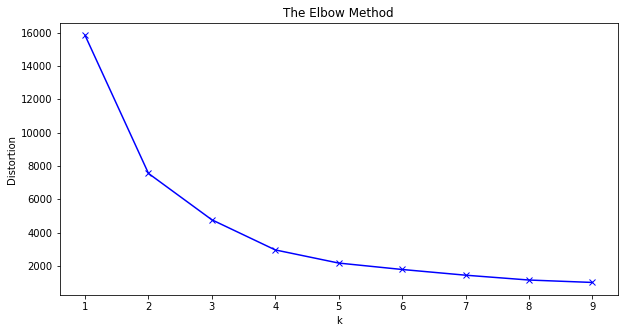

In [42]:
plt.figure(figsize=(10,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method')
plt.show()

From the above plot it can be seen that distortion drops significantly with k=2, and moderately for k=3 or k=4. Beyond that, a larger number of clusters do not add much value. Hence, we may proceed with k=2 and cluster areas into **'Go'** and **'No Go'** categories.

In [43]:
# set number of clusters
kclusters = 2

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 0])

Let's add the cluster labels to the dataframe.

In [44]:
# add clustering labels
df_onehot_grouped.drop(columns='Cluster Label', inplace=True, errors='ignore')
df_onehot_grouped.insert(1, 'Cluster Label', kmeans.labels_)
df_onehot_grouped.head()

,Address,Cluster Label,Auto,Bank,Commercial,Hotel,Nightlife,Restaurant
0,"Ajmera, Haveli, Pune District",0,1,2,2,23,18,2
1,"Ambad, Nashik, Nashik",1,5,1,0,15,11,0
2,"Asoda, Jalgaon, Jalgaon",1,1,0,0,0,0,0
3,"Baner, Pune City, Pune District",0,2,4,6,22,30,9
4,"Bavdhan, Mulshi, Pune District",1,1,4,2,6,29,2


<a id='itemC'></a>

## 3. Results and Discussion
<div style="text-align: right"><a href="#home"><i><font size = 3 align=right>Home</font ></i></a></div>

From the above, it can be clearly seen that cluster 0 has venues from all categories of interest, and hence, is a **Go** cluster. On the other hand, cluster 1 is a **No Go** cluster as it has very few or no venues in either one or more categories of interest.

We need to add coordinates for each address so as to plot them on the map. We can get the addresses from the original *df_addresses* by performing a join operation.

In [45]:
# Join dfs to get geo-coordinates for each address
df_onehot_merged = pd.merge(df_onehot_grouped, df_addresses, how='outer', left_on='Address', right_on='address')

In [46]:
# Drop the 'address' column
df_onehot_merged.drop(['address'], axis=1)
df_onehot_merged.head()

,Address,Cluster Label,Auto,Bank,Commercial,Hotel,Nightlife,Restaurant,address,addr_lat,addr_lng
0,"Ajmera, Haveli, Pune District",0,1,2,2,23,18,2,"Ajmera, Haveli, Pune District",18.633712,73.814069
1,"Ambad, Nashik, Nashik",1,5,1,0,15,11,0,"Ambad, Nashik, Nashik",19.949995,73.743146
2,"Asoda, Jalgaon, Jalgaon",1,1,0,0,0,0,0,"Asoda, Jalgaon, Jalgaon",21.041181,75.606734
3,"Baner, Pune City, Pune District",0,2,4,6,22,30,9,"Baner, Pune City, Pune District",18.564243,73.776857
4,"Bavdhan, Mulshi, Pune District",1,1,4,2,6,29,2,"Bavdhan, Mulshi, Pune District",18.507420,73.767407


#### Map existing dealer locations to the above addresses

Out of the above addresses, we need to identify those where the company already has dealers present. For this, we can add a check column referring to *df_honda['dlr_address']*.

In [47]:
dlr = df_honda['dlr_address']

In [48]:
type(dlr)

pandas.core.series.Series

In [49]:
addcheck = []
for addr in df_onehot_merged['Address']:
    addcheck.append(addr in dlr.values)

print(addcheck)

[False, False, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, True, False, False, False, False, True, False, False, False, False, True, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, True, False, True, False]


In [50]:
df_onehot_merged['DlrCheck'] = addcheck
df_onehot_merged.head()

,Address,Cluster Label,Auto,Bank,Commercial,Hotel,Nightlife,Restaurant,address,addr_lat,addr_lng,DlrCheck
0,"Ajmera, Haveli, Pune District",0,1,2,2,23,18,2,"Ajmera, Haveli, Pune District",18.633712,73.814069,False
1,"Ambad, Nashik, Nashik",1,5,1,0,15,11,0,"Ambad, Nashik, Nashik",19.949995,73.743146,False
2,"Asoda, Jalgaon, Jalgaon",1,1,0,0,0,0,0,"Asoda, Jalgaon, Jalgaon",21.041181,75.606734,True
3,"Baner, Pune City, Pune District",0,2,4,6,22,30,9,"Baner, Pune City, Pune District",18.564243,73.776857,False
4,"Bavdhan, Mulshi, Pune District",1,1,4,2,6,29,2,"Bavdhan, Mulshi, Pune District",18.507420,73.767407,True


Finally, let's create a Folium map to plot the resulting clusters

In [55]:
# create map
map_clusters = folium.Map(location=[MH_latitude-1, MH_longitude], zoom_start=7)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, dlr in zip(df_onehot_merged['addr_lat'], df_onehot_merged['addr_lng'], df_onehot_merged['Address'], df_onehot_merged['Cluster Label'], df_onehot_merged['DlrCheck']):
    
    if dlr == True:
        kcolor = '#002080'
        label = folium.Popup(str(poi) + ', Honda Dealer', parse_html=True)
    elif cluster == 0:
        kcolor = '#009933'
        label = folium.Popup(str(poi) + ', Cluster ' + str(cluster) + ': Go', parse_html=True)
    else: 
        kcolor = '#A00000'
        label = folium.Popup(str(poi) + ', Cluster ' + str(cluster) + ': No Go', parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        legend=True,
        color=kcolor,
        fill=True,
        fill_color=kcolor,
        fill_opacity=0.7).add_to(map_clusters)

In [56]:
map_clusters

Let's try and add a legend to the above map

In [57]:
# Code credit: https://github.com/gabrielepinto
# Code source: https://nbviewer.jupyter.org/gist/talbertc-usgs/18f8901fc98f109f2b71156cf3ac81cd

from branca.element import Template, MacroElement

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Legend</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#002080;opacity:0.7;'></span>Honda Dealer</li>
    <li><span style='background:#009933;opacity:0.7;'></span>Go</li>
    <li><span style='background:#A00000;opacity:0.7;'></span>No Go</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

map_clusters.get_root().add_child(macro)

map_clusters

#### To conclude, list all addresses where Honda can consider opening a dealership

In [58]:
df_final_addresses = df_onehot_merged[(df_onehot_merged['DlrCheck']==False) & (df_onehot_merged['Cluster Label']==0)]
df_final_addresses = df_final_addresses[['Address', 'addr_lat', 'addr_lng']]
df_final_addresses.reset_index(drop=True)

,Address,addr_lat,addr_lng
0,"Ajmera, Haveli, Pune District",18.633712,73.814069
1,"Baner, Pune City, Pune District",18.564243,73.776857
2,"Chinchwad, Haveli, Pune District",18.640355,73.791713
3,"D Ward, Mumbai City",18.959798,72.811909
4,"Dhantoli, Nagpur District",21.133944,79.080566
5,"Erandwana, Pune City, Pune District",18.508749,73.831843
6,"F/S Ward, Mumbai City",18.997860,72.846624
7,"Fatima Nagar, Pune City, Pune District",18.504510,73.902129
8,"Gandhi Baug, Nagpur District",21.150010,79.102428
9,"Ganesh Peth, Pune City, Pune District",18.515422,73.864737


<a id='itemD'></a>

## 4. Conclusion
<div style="text-align: right"><a href="#home"><i><font size = 3 align=right>Home</font ></i></a></div>

We have successfully identified prospective locations for new Honda dealerships based on criteria like economic activity, availability of finance, and lifestyle. While applying this project in a real-life situation, additional data or approximation thereof regarding market size, rival dealer sales etc. will be valuable and should be added to the analysis.

*This notebook is created for the Capstone project for IBM's Data Science Professional Certification on Coursera for educational purpose. This project is not commissioned by or executed by Honda Cars India Ltd. The methodology and resources used are entirely based on discretion of the author and may not be the same as that followed by Honda or any other OEM.*

<hr>

Amol Sangeet; 2020. [GitHub](https://github.com/amolrs/Coursera_Capstone) | [LinkedIn](https://www.linkedin.com/in/amolsangeet/)